In [33]:
import logging
import pyvista as pv

from pointcept.supplemental.utils import *
from pointcept.supplemental.mesh_processing import DataHandler, set_data_root, MeshAnalyser
from pointcept.supplemental.fold_allocation import (
    GridSplitter,
    plot_mesh_folds,
    crop_meshes_per_fold,
    save_fold_meshes
)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

set_data_root("../../data")
label = 'rog_south'

In [2]:
dh = DataHandler(label)
dh.ensure_meshes()

21:35:10 - INFO - Label rog_south already has extracted meshes.


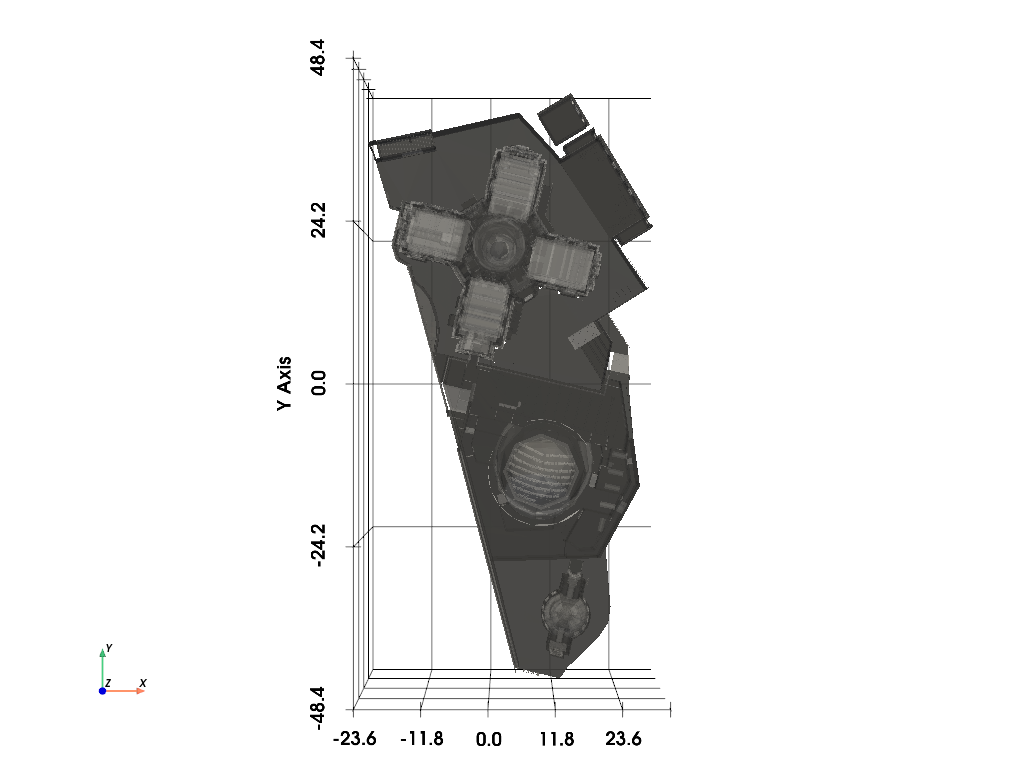

In [4]:
dh.plot_meshes()

In [6]:
analyser = MeshAnalyser(data_handler=dh)

In [7]:
to_exclude = []
pcds = analyser.generate_toy_pcds(resolution=0.15, excluded_categories=to_exclude)

21:36:06 - INFO - Generating toy pointclouds for categories ['1_WALL', '2_FLOOR', '3_ROOF', '4_CEILING', '5_FOOTPATH', '7_COLUMN', '8_DOOR', '9_WINDOW', '10_STAIR', '11_RAILING', '12_RWP', '13_OTHER'].
21:36:06 - INFO - Sampling with resolution 0.15.
21:36:06 - INFO - Number of points after initial sampling: 5515655
21:36:09 - INFO - Number of points after Poisson Disk Sampling: 481633
21:36:09 - INFO - Number of points after initial sampling: 696084
21:36:09 - INFO - Number of points after Poisson Disk Sampling: 140256
21:36:09 - INFO - Number of points after initial sampling: 378012
21:36:09 - INFO - Number of points after Poisson Disk Sampling: 44007
21:36:09 - INFO - Number of points after initial sampling: 1553631
21:36:10 - INFO - Number of points after Poisson Disk Sampling: 83679
21:36:10 - INFO - Number of points after initial sampling: 750448
21:36:10 - INFO - Number of points after Poisson Disk Sampling: 145095
21:36:10 - INFO - Number of points after initial sampling: 38353

In [8]:
binning = analyser.evaluate_binning(pcds, x_cell_width=6.0, y_cell_width=6.0)
counts = binning['counts']
x_edges = binning['x_edges']
y_edges = binning['y_edges']

21:36:11 - INFO - Binning is using 8 bins in X and 17 bins in Y based on cell widths of 6.0 and 6.0.


21:45:13 - INFO - New best equality score: 5000005040997.0078 at iteration 1
21:45:13 - INFO - New best equality score: 7615208.4208 at iteration 2
21:45:13 - INFO - New best equality score: 86401.8263 at iteration 7
21:45:14 - INFO - New best equality score: 80386.2763 at iteration 145
21:45:15 - INFO - New best equality score: 53333.4148 at iteration 294
21:45:16 - INFO - Number of unique seed cell configurations = 500


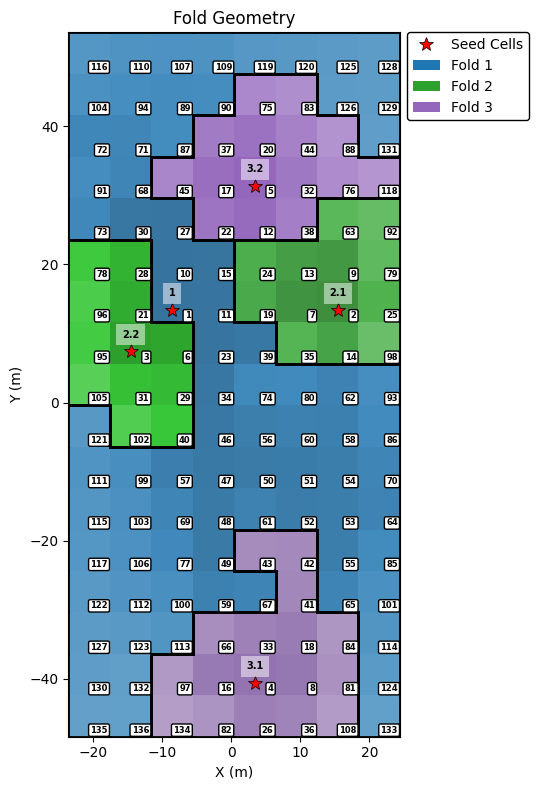

Iteration: 294

Fold Summaries:

Fold 1:
  Intended total counts: 592908.60
  Actual total counts: 468927.0
  Category Counts:
    1_WALL: 224504.0 (46.61% of total 1_WALL)
    2_FLOOR: 69446.0 (49.51% of total 2_FLOOR)
    3_ROOF: 15550.0 (35.34% of total 3_ROOF)
    4_CEILING: 52004.0 (62.15% of total 4_CEILING)
    5_FOOTPATH: 66119.0 (45.57% of total 5_FOOTPATH)
    7_COLUMN: 787.0 (26.00% of total 7_COLUMN)
    8_DOOR: 10266.0 (48.15% of total 8_DOOR)
    9_WINDOW: 4168.0 (35.93% of total 9_WINDOW)
    10_STAIR: 3664.0 (46.39% of total 10_STAIR)
    11_RAILING: 7906.0 (39.04% of total 11_RAILING)
    12_RWP: 809.0 (39.93% of total 12_RWP)
    13_OTHER: 13704.0 (50.04% of total 13_OTHER)
  Aspect Ratio: 2.12

Fold 2:
  Intended total counts: 197636.20
  Actual total counts: 229701.0
  Category Counts:
    1_WALL: 123972.0 (25.74% of total 1_WALL)
    2_FLOOR: 28753.0 (20.50% of total 2_FLOOR)
    3_ROOF: 9770.0 (22.20% of total 3_ROOF)
    4_CEILING: 14985.0 (17.91% of total 4_CEIL

In [24]:
weights = {1: 0.6, 2: 0.2, 3: 0.2}  # Intended area weights: training, evaluation, test
region_counts = {1: 1, 2: 2, 3: 2}
iterations = 500  # Number of iterations to run

# Create an instance of GridSplitter
grid_splitter = GridSplitter(
    counts=counts,
    x_edges=x_edges,
    y_edges=y_edges,
    weights=weights,
    iterations=iterations,
    region_counts=region_counts,
)
grid_splitter.min_percentage_threshold = 4.0

# Run the algorithm
grid_splitter.run()

# Access the best configuration
best_config = grid_splitter.best_configuration

# Plot the result
best_config.plot()

# Print the summary
best_config.print_summary()

21:45:27 - INFO - Fold 1, Region 1: Found 17 rectangles with total perimeter 140


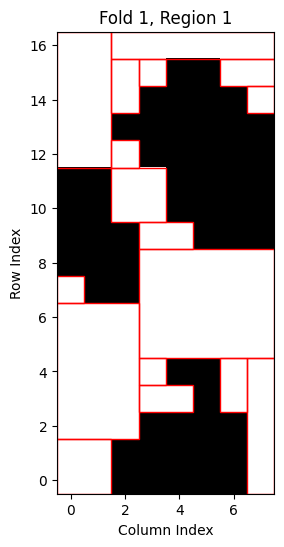

21:45:28 - INFO - Fold 2, Region 2: Found 3 rectangles with total perimeter 24


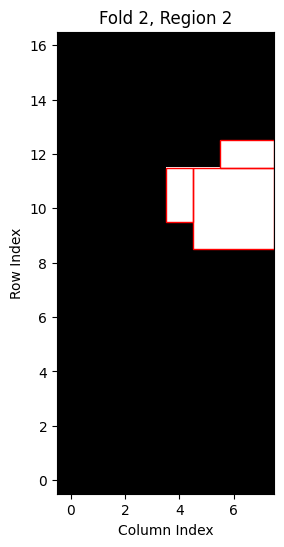

21:45:28 - INFO - Fold 2, Region 3: Found 3 rectangles with total perimeter 24


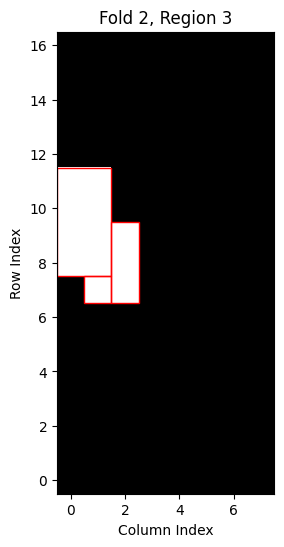

21:45:28 - INFO - Fold 3, Region 4: Found 4 rectangles with total perimeter 30


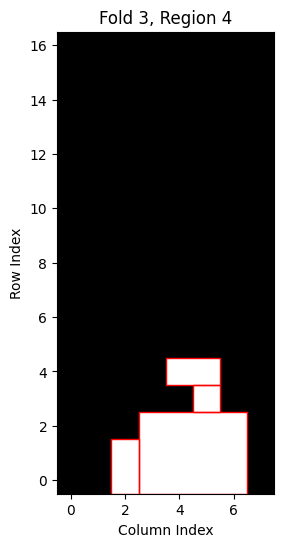

21:45:28 - INFO - Fold 3, Region 5: Found 5 rectangles with total perimeter 32


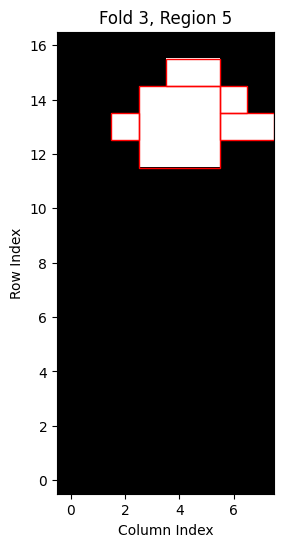

In [26]:
fold_rectangles = best_config.generate_fold_rectangles(combine_subregions=False)

In [27]:
fold_meshes = crop_meshes_per_fold(
    dh.extracted_meshes,
    fold_rectangles,
    best_config.x_edges,
    best_config.y_edges,
)

21:45:46 - INFO - Processing Region 1 in Fold 1
21:46:54 - INFO - Processing Region 2 in Fold 2
21:47:04 - INFO - Processing Region 3 in Fold 2
21:47:17 - INFO - Processing Region 4 in Fold 3
21:47:34 - INFO - Processing Region 5 in Fold 3


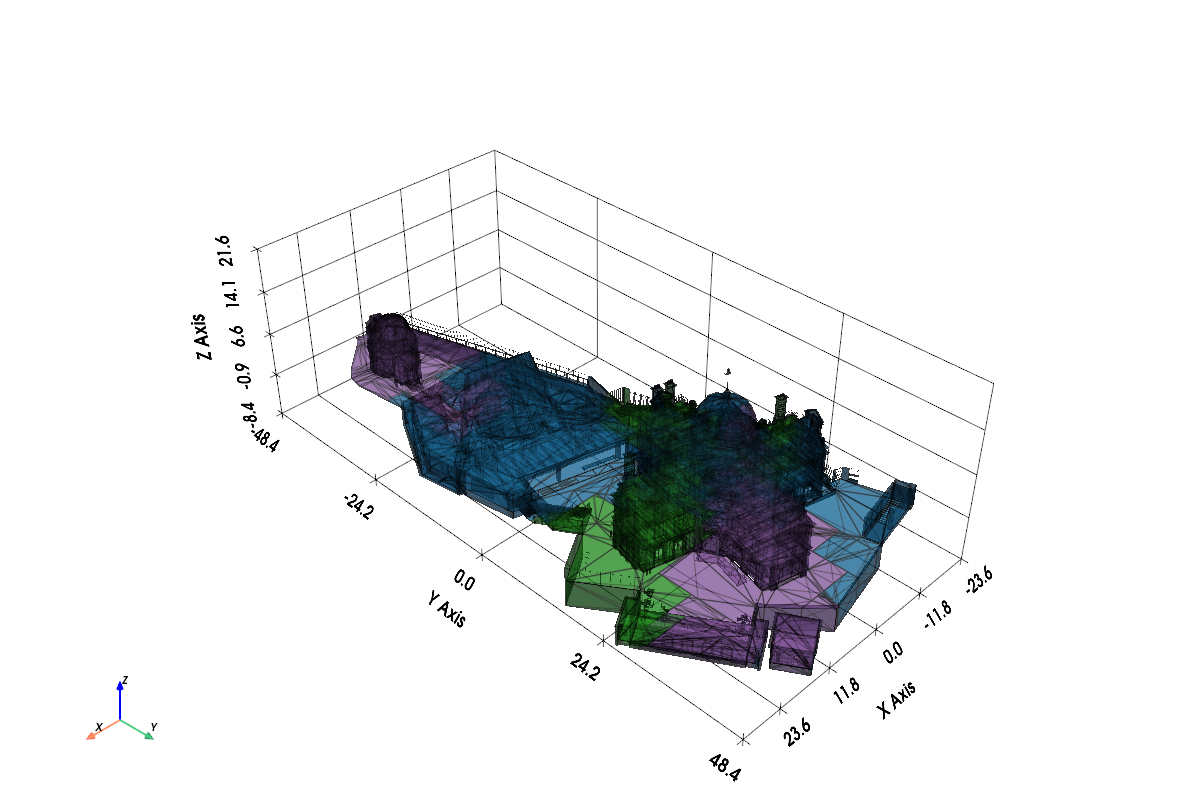

In [29]:
plot_mesh_folds(fold_meshes, backend='static', cmap='tab20')

In [31]:
best_config.save("../../fold_allocations/rog_south_v1.pkl")

In [44]:
save_fold_meshes(dh, fold_meshes)

15:32:59 - INFO - Saved Fold 1, Region 1, Category '1_WALL' to ../../data/meshes/extracted/rog_south/train/1_wall_sceneid1.ply.
15:32:59 - INFO - Saved Fold 1, Region 1, Category '2_FLOOR' to ../../data/meshes/extracted/rog_south/train/2_floor_sceneid1.ply.
15:32:59 - INFO - Saved Fold 1, Region 1, Category '3_ROOF' to ../../data/meshes/extracted/rog_south/train/3_roof_sceneid1.ply.
15:32:59 - INFO - Saved Fold 1, Region 1, Category '4_CEILING' to ../../data/meshes/extracted/rog_south/train/4_ceiling_sceneid1.ply.
15:32:59 - INFO - Saved Fold 1, Region 1, Category '5_FOOTPATH' to ../../data/meshes/extracted/rog_south/train/5_footpath_sceneid1.ply.
15:32:59 - INFO - Saved Fold 1, Region 1, Category '7_COLUMN' to ../../data/meshes/extracted/rog_south/train/7_column_sceneid1.ply.
15:32:59 - INFO - Saved Fold 1, Region 1, Category '8_DOOR' to ../../data/meshes/extracted/rog_south/train/8_door_sceneid1.ply.
15:32:59 - INFO - Saved Fold 1, Region 1, Category '9_WINDOW' to ../../data/meshes/e